In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [4]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


Generando 1000  recetas aleatorias...



100%|██████████| 1000/1000 [00:06<00:00, 147.38it/s]


array([[<AxesSubplot:title={'center':'kcal'}>]], dtype=object)

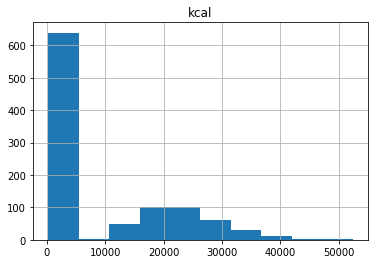

In [40]:
dftest = recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=3, max_unidades=11,
                                                  min_kcal=250, max_kcal= 2500,
                                                  numero_recetas=1000
                                                  )

dftest = pd.DataFrame(dftest, columns=['ingredientes', 'kcal', 'carbs', 'prot', 'grasas'])  
dftest[['kcal']].astype(float).hist()

* Entrenar información nutricional

In [53]:
recomendador128.NUM_RECETAS = 10000
recomendador128.EMB_SIZE = 128
ITER = 1
INITIAL_EPOCH = 0
EPOCHS = 35
BATCHSIZE = 32
LR = 1e-5

Rangos_kcal = [
                #(350, 1500),
                #(300, 1000)
                (250, 2500)          
              ]

Histories = []
for iteracion in range(ITER):
  MINU = 3 
  MAXU = 11  
  #INITIAL_EPOCH = 0

  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                  #df_training='recipes_con_info_nutricional.csv',
                                  df_test='recetas_test.csv', 
                                  df_val='recetas_val.csv',
                                  learning_rate=LR,
                                  version=version, 
                                  initial_epoch = INITIAL_EPOCH,                             
                                  epochs=INITIAL_EPOCH + EPOCHS, 
                                  batch_size=BATCHSIZE,
                                  kernels=128,                                             
                                  min_ingredientes=5, max_ingredientes=11,
                                  #min_ingredientes=3, max_ingredientes=16,
                                  min_unidades=MINU, max_unidades=MAXU,  
                                  min_kcal=MINK, max_kcal= MAXK,                             
                                  save=True, verbose=True)
    INITIAL_EPOCH = history.epoch[-1]

    Histories.append(history)



ITERACIÓN: 1
min unidades: 3  max unidades: 11
min kcal: 250  max kcal: 2500
Entrenando desde epoch 0
------------------------------------------

Error al cargar archivos NumPy.
datasets/numpy/10000_recetas_random_EMBED-128_DATA_X.npy no existe o está corrupto.
datasets/numpy/10000_recetas_random_EMBED-128_DATA_Y.npy no existe o está corrupto.
Generando 10000  recetas aleatorias...



100%|██████████| 10000/10000 [01:16<00:00, 130.23it/s]


Calculando vector de características de 10000 recetas...


  0%|          | 46/10000 [00:10<35:56,  4.62it/s]

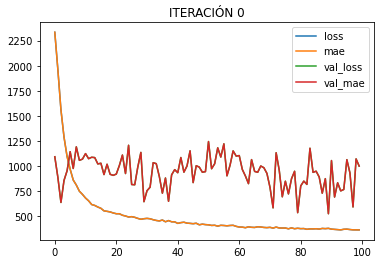

LOSS: 358.6531982421875  -- MAE: 358.6531982421875  -- VAL_LOSS: 996.2946166992188  -- VAL_MAE: 996.2946166992188
----------------------------------------------------------


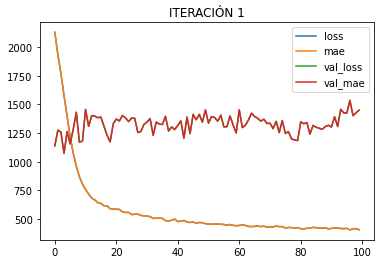

LOSS: 406.7725830078125  -- MAE: 406.7725830078125  -- VAL_LOSS: 1450.291015625  -- VAL_MAE: 1450.291015625
----------------------------------------------------------


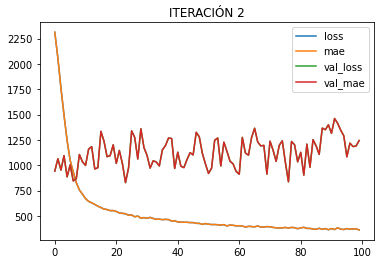

LOSS: 360.921630859375  -- MAE: 360.921630859375  -- VAL_LOSS: 1243.41455078125  -- VAL_MAE: 1243.41455078125
----------------------------------------------------------


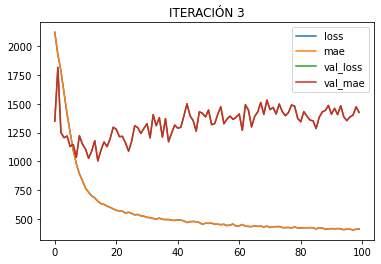

LOSS: 411.6185302734375  -- MAE: 411.6185302734375  -- VAL_LOSS: 1425.681396484375  -- VAL_MAE: 1425.681396484375
----------------------------------------------------------


In [7]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios


ITERACIÓN: 1
Entrenando desde epoch 0
------------------------------------------

Generando 100  recetas aleatorias...



100%|██████████| 100/100 [00:00<00:00, 396.31it/s]


Calculando vector de características de 100 recetas...


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_9 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

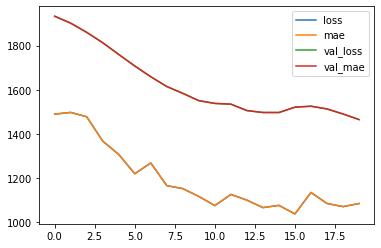

1/1 [==============================] - 0s 357ms/step - loss: 168.5878 - mae: 168.5878
[168.5878448486328, 168.5878448486328]
1/1 [==============================] - 0s 360ms/step
receta 0 precio_prom_por_gramo_true: 17.34 precio_prom_por_gramo_pred: 28.393808  precisión: 61.1 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 176.2 precio_prom_por_gramo_pred: 134.73662  precisión: 76.4 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 12104.0 precio_prom_por_gramo_pred: 11187.484  precisión: 92.4 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 28.03 precio_prom_por_gramo_pred: 0.0  precisión: 0.0 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 499.8 precio_prom_por_gramo_pred: 537.23615  precisión: 93.0 %
-----------------------

100%|██████████| 100/100 [00:00<00:00, 334.23it/s]


Calculando vector de características de 100 recetas...


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_10 (Bat  (None, 128, 768)         3072      
 chNormalization)                                                
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

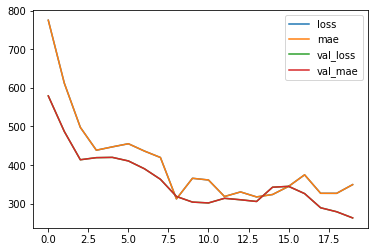

1/1 [==============================] - 0s 308ms/step - loss: 2222.9263 - mae: 2222.9263
[2222.92626953125, 2222.92626953125]
1/1 [==============================] - 0s 275ms/step
receta 0 precio_prom_por_gramo_true: 229.6 precio_prom_por_gramo_pred: 151.47485  precisión: 66.0 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 212.5 precio_prom_por_gramo_pred: 347.7243  precisión: 61.1 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 600.5 precio_prom_por_gramo_pred: 532.62994  precisión: 88.7 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 9950.0 precio_prom_por_gramo_pred: 130.0047  precisión: 1.3 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 634.0 precio_prom_por_gramo_pred: 655.0654  precisión: 96.8 %
---------------------

In [12]:
recomendador128.NUM_RECETAS = 500
recomendador128.EMB_SIZE = 128
ITER = 10
INITIAL_EPOCH = 0
EPOCHS = 15
BATCHSIZE = 32


Histories_precios = []
for iteracion in range(ITER):
    print('\nITERACIÓN:', iteracion+1)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                    df_precios='lista_precios_profeco_2022.csv',                                   
                                    learning_rate=1e-3,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    batch_size=BATCHSIZE,
                                    kernels=128,                                                                         
                                    save=True, verbose=True)
    INITIAL_EPOCH = history_precios.epoch[-1]

    Histories_precios.append(history_precios)

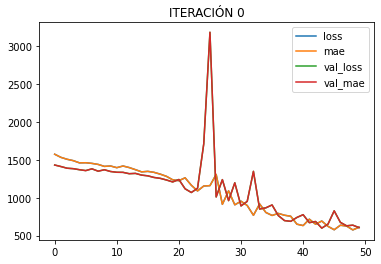

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


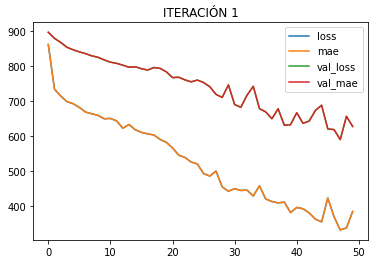

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')